# Analysis of ToxCast Data Used by the Silent Spring Institute's EHP Paper ([Cardona and Rudel, 2021](https://ehp.niehs.nih.gov/doi/10.1289/EHP8608))

Date: 10/5/2021

Author: Lyle D. Burgoon, Ph.D.

# Background

Cardona and Rudel (2021) published a study where they purport to identify chemicals that increase estrogen or progesterone levels in a ToxCast assay. They generated two lists of chemicals -- one for chemicals that increase estrogen levels, and one that increase progesterone levels.

# Purpose

The purpose of this analysis is to identify if the chemicals identified in Cardona and Rudel (2021) are actually changing the levels of estrogen or progesterone as measured in the high throughput H295R ToxCast assay. Part of this analysis will focus on data quality, while the other part will focus on a statistical analysis. 

We are going to query our local copy of the invitroDB -- the database that contains the ToxCast data. We downloaded [invitroDBv3.3](https://gaftp.epa.gov/COMPTOX/High_Throughput_Screening_Data/InVitroDB_V3.3/MySQL_Data/INVITRODB_V3_3_MYSQL.zip) from the [US EPA's ToxCast Download page](https://www.epa.gov/chemical-research/exploring-toxcast-data-downloadable-data).

We used [MySQL 5.7.35 Community Server](https://dev.mysql.com/downloads/mysql/5.7.html) to ensure we were using the same version of MySQL that invitroDB was built on.

# Database Queries

For various reasons, security being chief among them, I'm running my database queries outside of this Jupyter notebook, and exporting the results to text files. I'm then reading the text files into this notebook for further analysis and visualization. However, I will include the SQL code in this notebook so you can see what queries I ran to get the data being used.

Note: I also added 2 new tables to invitroDB to capture the chemicals identified by the silent_spring_institute: the estrogen up chemicals are in the table "chemicals_silent_spring_identified" which consists of a primary key, a column called chemical_name, and a column called casn for the CASRN.. The progesterone up chemicals are in the table "chemicals_silent_spring_identified_p4" which consists of a primary key, a column called chemical_name, and a column called casn for the CASRN.

# Initialize R Environment

In [1]:
library(ggplot2)
library(dplyr)
library(rstan)
library(bayesplot)
library(stringr)

options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

set.seed(530727)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: StanHeaders

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file

This is bayesplot version 1.8.1

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting



# Challenge 1: Low Number of Replicates

The US EPA has always been very careful about how they talk about ToxCast, and they have been clear that they tend to use a smaller number of replicates per concentration so that they could screen more chemicals. We are going to look at the distribution of number of samples used in the dataset reported by Cardona and Rudel, 2021.

Note: All of the hormones are being measured simultaneously. What this means is that the number of replicates per chemical concentration is the same across all hormones. Thus, we only need to run one query for estrogen increase and one for progesterone increase to get accurate counts of replicates per chemical concentration.

## Estrogen Increase

For the estrogen increase dataset, I ran the following SQL query:

11-deoxycortisol:

```
select assay_component.assay_component_name, assay_component.technological_target_type_sub, chemical.chnm, mc0.conc, count(*)
from mc0 
JOIN sample ON mc0.spid = sample.spid 
JOIN chemical ON sample.chid = chemical.chid 
JOIN chemicals_silent_spring_identified on chemicals_silent_spring_identified.casn = chemical.casn 
JOIN assay_component on assay_component.acid = mc0.acid 
WHERE mc0.acid = 594
GROUP BY assay_component.assay_component_name, assay_component.technological_target_type_sub, chnm, mc0.conc 
ORDER BY chnm, conc;
```

I output this data into the this file:./invitrodb_queries/estrogen_up_queries_and_data/estrogen_assay_counts.txt

Let's look at the distribution of samples or replicates per chemical concentration:

Warning message:
"Removed 37 rows containing missing values (geom_violin)."


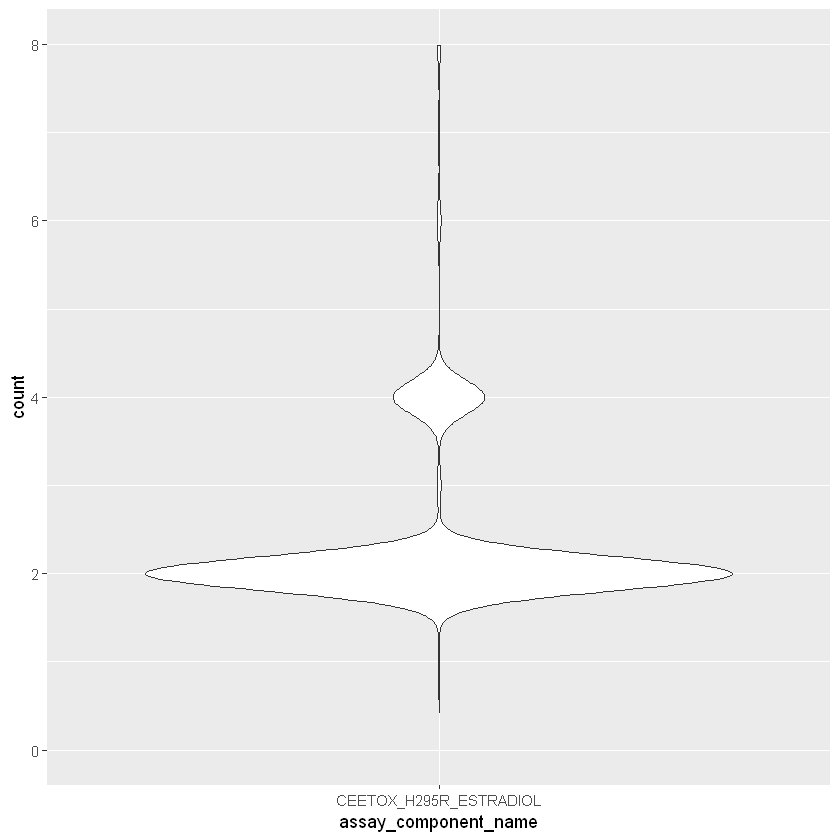

In [2]:
chem_conc_count <- read.table(file = "./invitrodb_queries/estrogen_up_queries_and_data/estrogen_assay_counts.txt", sep="\t", header=TRUE)
ggplot(chem_conc_count, aes(x=assay_component_name, y=count...)) +
    geom_violin(trim=FALSE) +
    ylim(c(0,max(chem_conc_count$count...))) +
    ylab("count")


This next block will write out the histogram to file

In [3]:
png("estrogen_conc_count.png", width=5000, height=5000, res=600)
ggplot(chem_conc_count, aes(x=assay_component_name, y=count...)) +
    geom_violin(trim=FALSE) +
    ylim(c(0,max(chem_conc_count$count...))) +
    ylab("count")
dev.off()

Warning message:
"Removed 37 rows containing missing values (geom_violin)."


png 
  2

It's clear -- most chemical concentrations only have 2 samples. A far smaller number have 4. And a very small number have 3, 6 or 8. How does this all breakdown?

In [4]:
x_total <- length(chem_conc_count$count...)
x_1 <- length(which(chem_conc_count$count... == 1))
x_2 <- length(which(chem_conc_count$count... == 2))
x_3 <- length(which(chem_conc_count$count... == 3))
x_4 <- length(which(chem_conc_count$count... == 4))
x_5 <- length(which(chem_conc_count$count... == 5))
x_6 <- length(which(chem_conc_count$count... == 6))
x_7 <- length(which(chem_conc_count$count... == 7))
x_8 <- length(which(chem_conc_count$count... == 8))

x_df <- data.frame(number_replicates = c(1, 2,3,4,5,6,7,8),
          count = c(x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8),
          percentage = c(x_1/x_total, x_2/x_total, x_3/x_total, x_4/x_total, x_5/x_total, x_6/x_total, x_7/x_total, x_8/x_total))
x_df
x_total

number_replicates,count,percentage
<dbl>,<int>,<dbl>
1,2,0.001968504
2,862,0.848425197
3,6,0.005905512
4,134,0.131889764
5,0,0.000000000
6,6,0.005905512
7,1,0.000984252
8,5,0.004921260


[1] 1016

## Progesterone Increase

For the progesterone increase dataset, I ran the following SQL query:

11-deoxycortisol:

```
select assay_component.assay_component_name, assay_component.technological_target_type_sub, chemical.chnm, mc0.conc, count(*)
from mc0 
JOIN sample ON mc0.spid = sample.spid 
JOIN chemical ON sample.chid = chemical.chid 
JOIN chemicals_silent_spring_identified_p4 on chemicals_silent_spring_identified_p4.casn = chemical.casn
JOIN assay_component on assay_component.acid = mc0.acid 
WHERE mc0.acid = 597
GROUP BY assay_component.assay_component_name, assay_component.technological_target_type_sub, chnm, mc0.conc 
ORDER BY chnm, conc;
```

I output this data into the this file:./invitrodb_queries/progesterone_up_queries_and_data/progesterone_assay_counts.txt

Let's look at the distribution of samples or replicates per chemical concentration:

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
"EOF within quoted string"
Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
"number of items read is not a multiple of the number of columns"
Warning message:
"Removed 1 rows containing non-finite values (stat_ydensity)."


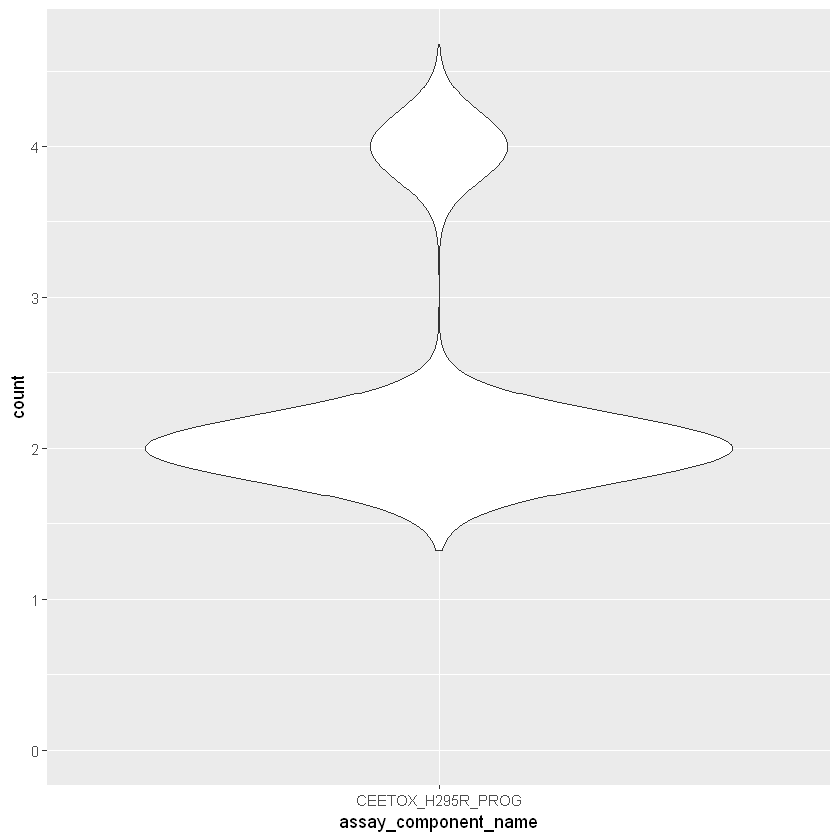

In [5]:
chem_conc_count <- read.table(file = "./invitrodb_queries/progesterone_up_queries_and_data/progesterone_assay_counts.txt", sep="\t", header=TRUE)
ggplot(chem_conc_count, aes(x=assay_component_name, y=count...)) +
    geom_violin(trim=FALSE) +
    ylim(c(0,max(chem_conc_count$count...))) +
    ylab("count")

This next block will write out the histogram to file

In [6]:
png("progesterone_conc_count_progesterone.png", width=5000, height=5000, res=600)
ggplot(chem_conc_count, aes(x=assay_component_name, y=count...)) +
    geom_violin(trim=FALSE) +
    ylim(c(0,max(chem_conc_count$count...))) +
    ylab("count")
dev.off()

Warning message:
"Removed 1 rows containing non-finite values (stat_ydensity)."


png 
  2

It's clear -- most chemical concentrations only have 2 samples. A far smaller number have 4. How does this all breakdown?

In [7]:
x_total <- length(chem_conc_count$count...)
x_1 <- length(which(chem_conc_count$count... == 1))
x_2 <- length(which(chem_conc_count$count... == 2))
x_3 <- length(which(chem_conc_count$count... == 3))
x_4 <- length(which(chem_conc_count$count... == 4))
x_5 <- length(which(chem_conc_count$count... == 5))
x_6 <- length(which(chem_conc_count$count... == 6))
x_7 <- length(which(chem_conc_count$count... == 7))
x_8 <- length(which(chem_conc_count$count... == 8))

x_df <- data.frame(number_replicates = c(1, 2,3,4,5,6,7,8),
          count = c(x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8),
          percentage = c(x_1/x_total, x_2/x_total, x_3/x_total, x_4/x_total, x_5/x_total, x_6/x_total, x_7/x_total, x_8/x_total))

x_df

number_replicates,count,percentage
<dbl>,<int>,<dbl>
1,0,0.0000000
2,244,0.8079470
3,0,0.0000000
4,57,0.1887417
5,0,0.0000000
6,0,0.0000000
7,0,0.0000000
8,0,0.0000000


This makes it clear -- there are very few replicates per concentration overall within the chemicals used for the progesterone increase dataset. This is not at all surprising, in fact, it is by design. However, what this means is that the data are at a very high risk of bias due to sampling error. Keep in mind, ToxCast was intended to be used for chemical screening and it is fit for purpose for hypothesis generation. However, scientists and regulators must not draw definitive conclusions based on data from ToxCast.

# Challenge 2: Statistical Analysis

Having so few replicates makes it challenging to identify if there is a treatment effect. The reason why is because small numbers of replicates drives sampling bias, which tends to favor false positive effects. In addition, we lack a biological significance level for this assay. 

## Example: Coumaphos

Coumaphos was identified by Cardona and Rudel as significantly driving estrogen production levels by about 4x. But is this real? Let's check it out.

I'm going to start by looking at the DMSO data. Fortunately, we have a lot of DMSO data. Given that we have technical replicates on each plate for DMSO, we have a lot of exchangeable data. I'm interested in trying to model the plate effects, with the understanding that it may not be as successful as I would like, given the fact we have so few replicates per plate. However, here's a start:

### 1. DMSO: Build the dataset

I'm going to read in the data from ToxCast (invitroDB), and then I'm going to summarize this information.

Here's the SQL:
```
select mc0.spid, mc0.apid, mc0.rowi, mc0.coli, mc0.wllt, mc0.wllq, mc0.conc, mc0.rval
from mc0  
WHERE mc0.spid = "DMSO"
AND mc0.acid = 594
LIMIT 0, 1000
```


In [8]:
dmso_estrogen <- as_tibble(read.table(file = "./invitrodb_queries/estrogen_up_queries_and_data/dmso_estradiol_levels.txt", sep="\t", header=TRUE))
dmso_estrogen_summary <- dmso_estrogen %>% group_by(apid) %>% summarize(mean=mean(rval), se=sd(rval)/sqrt(n()))

In [9]:
head(dmso_estrogen_summary)

apid,mean,se
<chr>,<dbl>,<dbl>
02Apr14.Plate.2,0.570,0.010
02Apr2014.Plate.1,0.495,0.035
02Apr2014.Plate.10,0.565,0.005
02Apr2014.Plate.11,0.650,0.020
02Apr2014.Plate.12,0.550,0.010
02Apr2014.Plate.13,0.655,0.005


There are some NAs in the dataset that need to reckoned with. These happen when there is only one replicate on the plate. I'm going to substitute the mean of the standard errors for the NA values. In addition, there are a few 0's in the standard error column -- that's also not possible, so I'm giving them the mean value.

In [10]:
dmso_estrogen_summary[which(is.na(dmso_estrogen_summary$se)), 3] <- mean(dmso_estrogen_summary$se, na.rm=TRUE)
dmso_estrogen_summary[which(dmso_estrogen_summary$se == 0), 3] <- mean(dmso_estrogen_summary$se, na.rm=TRUE)
which(is.na(dmso_estrogen_summary$se))

integer(0)

### 2. DMSO: Build the Hierarchical Model

This is going to be a relatively straightforward hierarchical model. It's based on the Eight Schools example that's common when learning Stan. Basically, instead of schools, I have plates. And what we're trying to figure out is that mean DMSO effect on estrogen levels. And we'll be able to see what the plate effect is, too.

The Stan code is in dmso.stan.

### 3. DMSO: Prepare the data

Put the information together into a list (that's how Stan prefers things).


In [11]:
dmso_data <- list(J = nrow(dmso_estrogen_summary),
                  y = dmso_estrogen_summary$mean,
                  sigma = dmso_estrogen_summary$se)

### 4. DMSO: Run the model

In [12]:
#dmso_fit <- stan(
#                file = "dmso_ncp.stan",
#                data = dmso_data,
#                chains = 3,
#                warmup = 10000,
#                iter = 15000,
#                control = list(max_treedepth = 15))

#dmso_mod_ncp <- stan_model("dmso_ncp.stan")
dmso_mod_cp <- stan_model("dmso.stan")
dmso_fit <- sampling(
                dmso_mod_cp,
                data = dmso_data,
                chains = 3,
                warmup = 10000,
                iter = 15000,
                control = list(max_treedepth = 15))

I ran both the ncp and the cp (ncp is non-centered model and cp is the centered model; they're alternative parameterizations of the same model). The NCP model ended up giving a ton of ESS issues, so I decided to go with CP. What this means is that CP ended up yielding a better exploration of the posterior space.

In [13]:
posterior_cp <- as.array(dmso_fit)
np_cp <- nuts_params(dmso_fit)
dmso_fit

Inference for Stan model: dmso.
3 chains, each with iter=15000; warmup=10000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=15000.

            mean se_mean   sd   2.5%    25%   50%   75% 97.5% n_eff Rhat
mu          0.44    0.00 0.03   0.39   0.42  0.44  0.46  0.50 33484    1
tau         0.38    0.00 0.02   0.34   0.37  0.38  0.40  0.43 30065    1
theta[1]    0.57    0.00 0.01   0.55   0.56  0.57  0.58  0.59 35602    1
theta[2]    0.49    0.00 0.03   0.43   0.47  0.49  0.52  0.56 34565    1
theta[3]    0.56    0.00 0.01   0.55   0.56  0.56  0.57  0.57 33922    1
theta[4]    0.65    0.00 0.02   0.61   0.64  0.65  0.66  0.69 33048    1
theta[5]    0.55    0.00 0.01   0.53   0.54  0.55  0.56  0.57 34945    1
theta[6]    0.65    0.00 0.01   0.65   0.65  0.65  0.66  0.66 35643    1
theta[7]    0.68    0.00 0.00   0.68   0.68  0.68  0.69  0.69 34109    1
theta[8]    0.63    0.00 0.02   0.59   0.62  0.63  0.65  0.68 35575    1
theta[9]    0.60    0.00 0.03   0.55   0.59 

Next, I'm going to run a diagnostic plot, just to see how things are going. Based on what I'm seeing above, I'm really comfortable with this parameterization of the hierarchical model. Basically, I have my overall treatment effect, and I have a good idea of what the different plate effects are. 

Keep in mind mu, $\mu$, is the treatment mean, tau, $\tau$, is the treatment standard deviation, and each of the thetas, $\theta [i]$, are the individual plate effects.

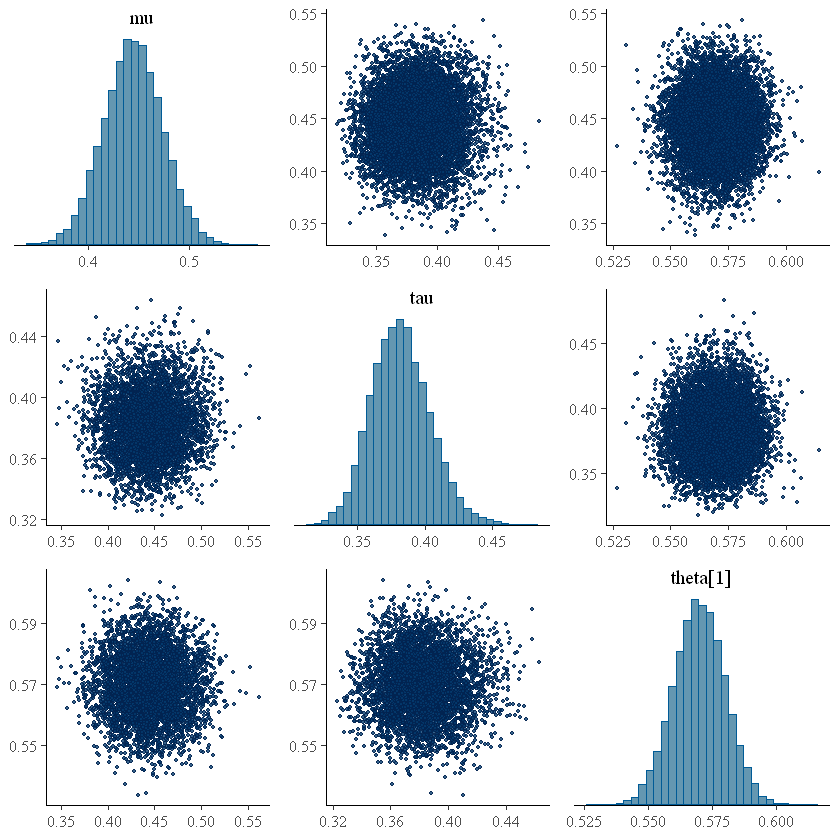

In [14]:
mcmc_pairs(posterior_cp, np = np_cp, pars = c("mu","tau","theta[1]"),
           off_diag_args = list(size = 0.75))

The diagnostic plots here are looking good. This is what I'd expect given there were no issues/warnings thrown by Stan.

So, we have a treatment mean of 0.44 and a standard deviation of 0.38. 

Out of curiosity, I'm wondering what the pooled mean and standard deviation would have been (simple average and standard deviation without doing the hierarchical modeling). Let's see:

In [15]:
dmso_estrogen %>% summarize(mean=mean(rval), sd=sd(rval))

mean,sd
<dbl>,<dbl>
0.4235394,0.37649


Kinda cool that really, at the end of the day, the mean from the hierarchical model is pretty close to the simple pooled mean and standard deviation of 0.42 and 0.38. This means that the plate effects aren't really all that much. It also means that the distribution is actually relatively flat.

I'm going to use the hierarchical model mean and standard deviation going forward. And here's what the histogram looks like:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



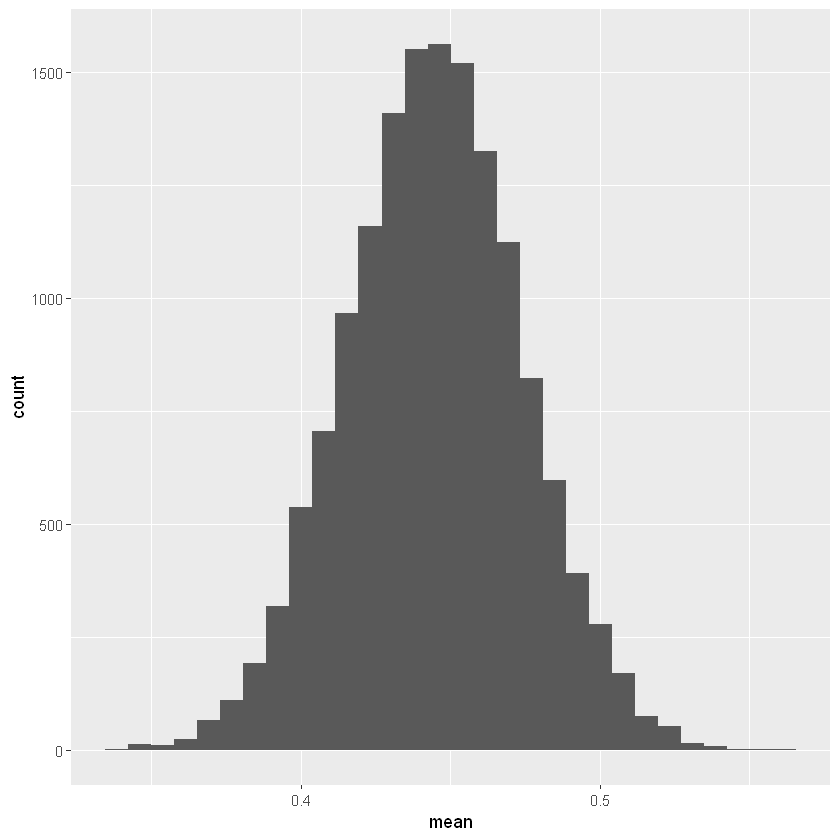

2.5%       50%     97.5% 
0.3871958 0.4446735 0.5023146

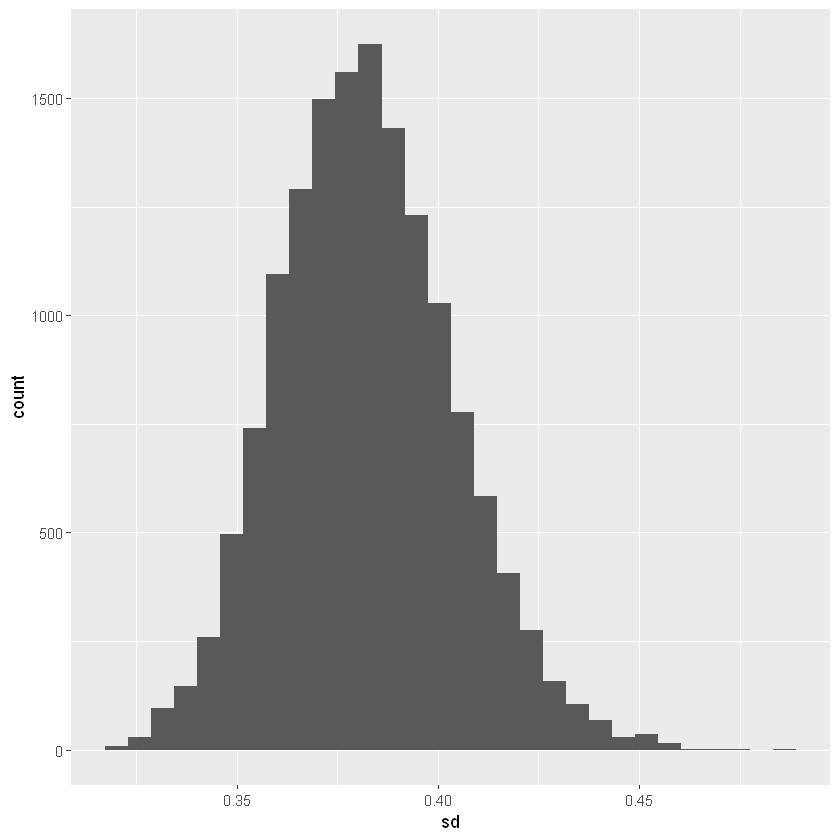

In [16]:
dmso_mean_distro <- extract(dmso_fit)$mu
dmso_sd_distro <- extract(dmso_fit)$tau

dmso_mean_sd_distro_df <- data.frame(mean = dmso_mean_distro, sd = dmso_sd_distro)

ggplot(dmso_mean_sd_distro_df, aes(x=mean)) +
    geom_histogram()

ggplot(dmso_mean_sd_distro_df, aes(x=sd)) +
    geom_histogram()

quantile(dmso_mean_distro, c(0.025, 0.5, 0.975))

So we can see that the mean has a median of 0.44 and a Bayesian interval of [0.39, 0.50]. Thus, the mean and median are likely within that range.

### 5. Coumaphos: Build the dataset

I queried the invitroDB to obtain the coumaphos data:

```
select assay_component.assay_component_name, assay_component.technological_target_type_sub, chemical.chnm, chemical.casn, sample.stkc, sample.stkc_unit, mc0.apid, mc0.rowi, mc0.coli, mc0.wllt, mc0.wllq, mc0.conc, mc0.rval
from mc0
JOIN sample ON mc0.spid = sample.spid
JOIN chemical ON sample.chid = chemical.chid
JOIN chemicals_silent_spring_identified on chemicals_silent_spring_identified.casn = chemical.casn
JOIN assay_component on assay_component.acid = mc0.acid
AND mc0.acid = 594
AND chnm = "Coumaphos"  
ORDER BY chnm, conc;
```

The 10$\mu$M coumaphos concentration had the highest amount of estrogen at 0.256$\mu$g/L and 0.35$\mu$g/L. If we divide those values by 272.4g/mol we can get the concentration in $\mu$M: 

In [17]:
0.256/272.4
0.350/272.4

[1] 0.0009397944

[1] 0.001284875

10$\mu$M coumaphos resulted in 0.000939 $\mu$M and 0.00128 $\mu$M estrogen being produced. But we're going to do our analysis using the $\mu$g/L values to keep things simple.

### 6. Coumaphos: Build the Model

In this case we don't have enough information to build a hierarchical model. We are actually kinda stuck. Most toxcast chemical concentrations are run on only one plate. So we can't model out a plate effect to get a treatment effect, like we did for DMSO.

In some ways, the ToxCast design is similar to what we have with microarrays. With microarrays we have a lot of glass slides, or sections of glass slides, that are in some ways analogous to the plates. There, we would normalize across the microarrays because we know there are microarray effects that we need to separate from the treatment effects. However, with the ToxCast data we lack the replicate plates -- so we can't just normalize our way out. Also, with microarrays we know why we have microarray level effects, and for that reason, we know that those effects are going to impact both color channels (when using 2-color arrays) equally. With the ToxCast data, we do not know that the plate level effects seen in DMSO will be the same as the plate-level effects we see with the chemical of interest. Thus, we can't just assume that by "adjusting" the signal for a chemical of interest to the same degree we would need to adjust the DMSO would actually make the right kind of difference.

Instead, I'm going to assume that the mean from the replicates at a single concentration is the same as the mean for the population. I know it's not. But I don't have many other options. I am also going to assume that the distribution has the same standard deviation as the model-level standard deviation. What this will get me is a rough estimate of the population distribution across multiple plates, assuming the mean I have is an accurate representation of the actual mean (which I honestly don't believe it is, but this is the best I can do). 

I will use the model-based information to estimate the DMSO estrogen level distribution. Since I cannot estimate what the means are for the chemical of interest, here it is coumaphos, I will perform the comparison based on the model-derived mean and model level standard deviation. I will then compare the coumaphos and DMSO distributions to see if they are different or similar.

### 7. Coumaphos: Prepare the data

I'm going to build the coumaphos distribution as described above. Note that I can't have negative estrogen values. So I'm going to use the ```repeat``` function. What this function will do is to repeat the code block it's fed until the ```break``` condition is met. So here, if the value from ```rnorm``` is negative, then repeat is going to repeat the ```rnorm``` until it gets a positve value.

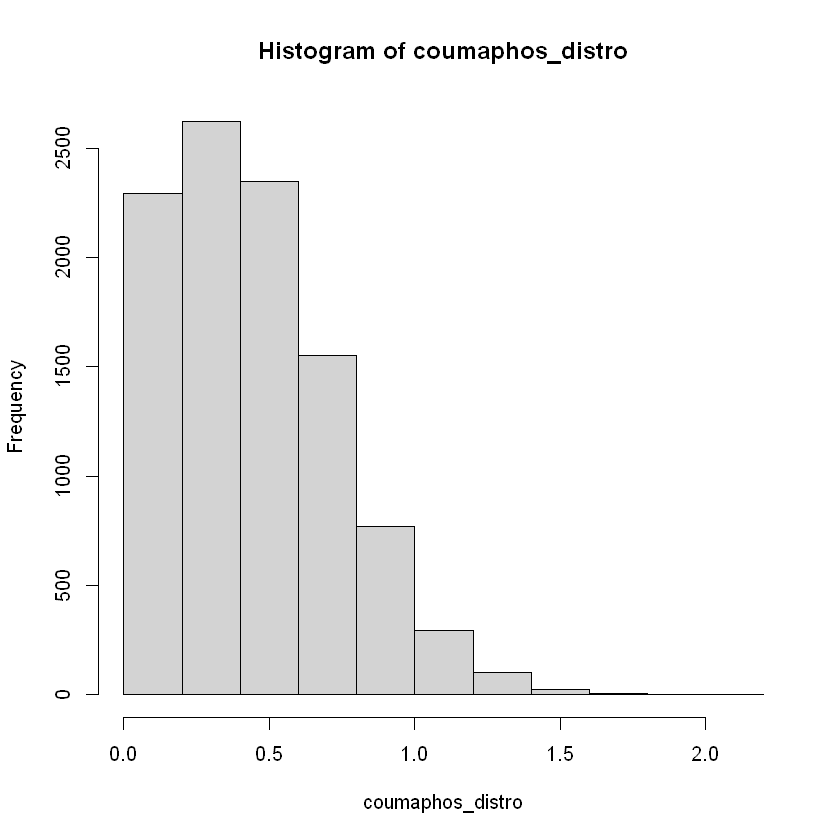

In [18]:
coumaphos_distro <- vector(mode="double", length = 10000)
for(i in 1:10000){
    repeat{
        coumaphos_distro[i] <- rnorm(1, (0.256+0.350)/2, dmso_sd_distro[i])
        if(length(which(coumaphos_distro < 0)) == 0){break}
    }
}
hist(coumaphos_distro)

In [19]:
png("coumaphos_distro.png", width=5000, height=5000, res=600)
hist(coumaphos_distro)
dev.off()

png 
  2

To get the DMSO distribution, I'm going to do something similar.

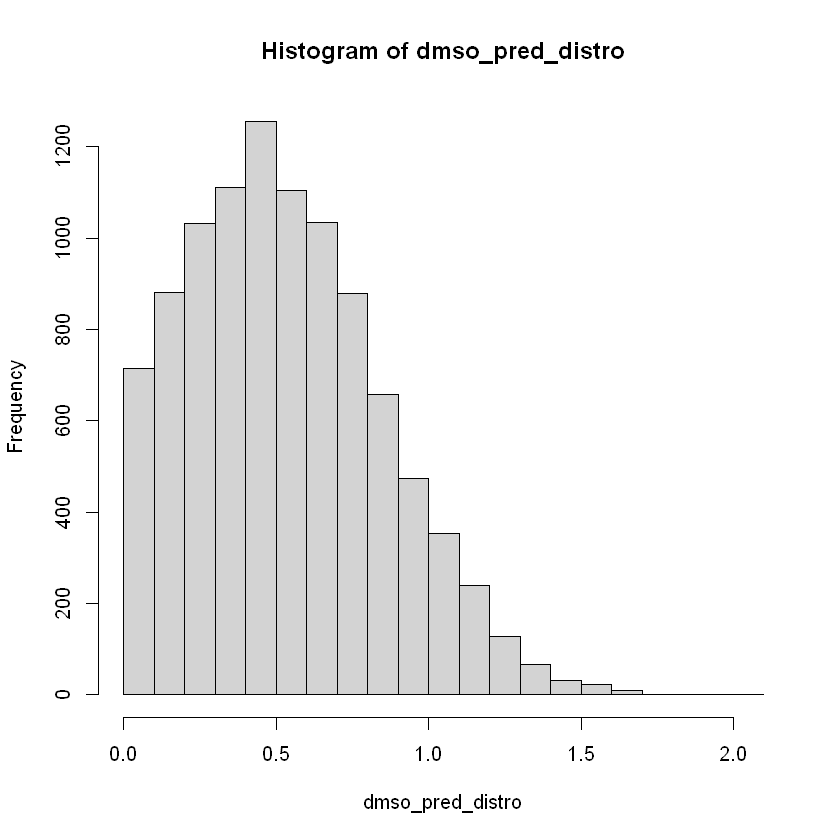

In [20]:
dmso_pred_distro <- vector(mode="double", length = 10000)
for(i in 1:10000){
    repeat{
        dmso_pred_distro[i] <- rnorm(1, dmso_mean_distro[i], dmso_sd_distro[i])
        if(length(which(dmso_pred_distro < 0)) == 0){break}
    }
}
hist(dmso_pred_distro)

In [21]:
png("dmso_pred_distro.png", width=5000, height=5000, res=600)
hist(dmso_pred_distro)
dev.off()

png 
  2

### 8. Coumaphos: Run the Model

I'm going to calculate the difference distribution, and analyze that. The 95% highest density interval of the difference distro needs to be at least 200pg/mL to be considered biologically relevant. This value is based on levels seen during the preovulatory LH surge of 200-500pg/mL.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



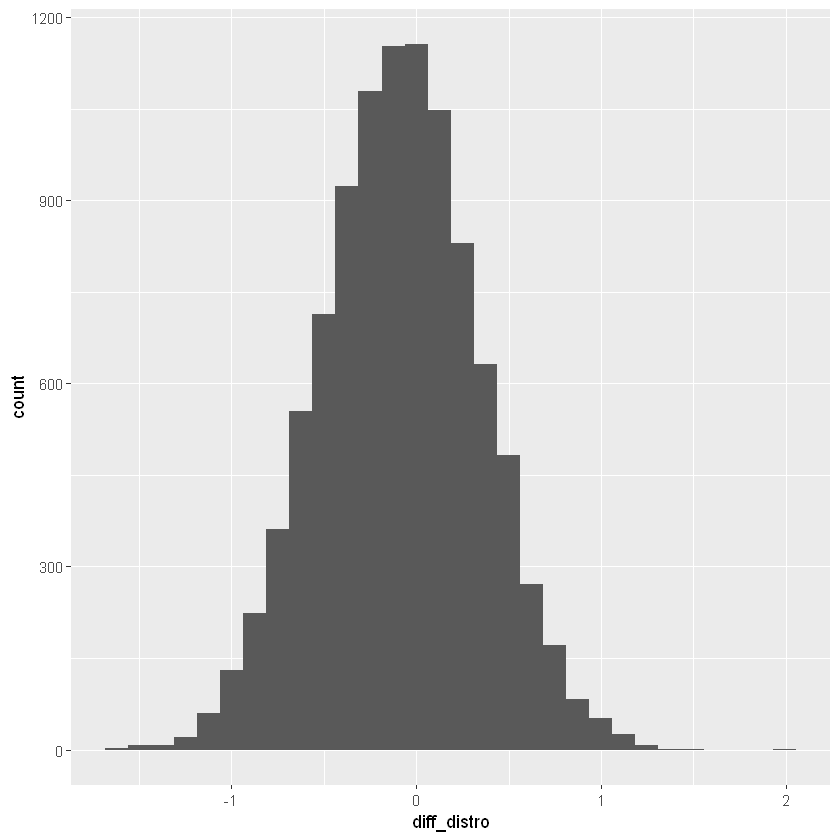

In [22]:
diff_distro <- coumaphos_distro - dmso_pred_distro
diff_distro_df <- data.frame(difference = diff_distro)
ggplot(diff_distro_df, aes(x=diff_distro)) +
    geom_histogram()

In [23]:
png("diff_distro.png", width=5000, height=5000, res=600)
ggplot(diff_distro_df, aes(x=diff_distro)) +
    geom_histogram()
dev.off()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



png 
  2

The histogram shows quite clearly that there is not much of a difference between the two distributions. In other words, contrary to the finding in Cardona and Rudel (2021), coumaphos is not actually increasing estrogen levels.

So what happened? Cardona and Rudel (2021) reported a fold change of 4.058, and here we are seeing that a fold change of 1.0 is a highly likely value. 

For starters, Cardona and Rudel (2021) did not look at the DMSO values as a distribution. Instead, they looked at the DMSO values on the same plate as the chemical. In other words, Cardona and Rudel ignored the fact that there can be plate-to-plate variance, and they ignored the fact that we need to treat the data as a distribution instead of just point estimates.

Coumaphos is on 20130320.Plate.6. As mentioned previously, coumaphos at the 10$\mu$M concentration had a mean estrogen production of 0.303$\mu$g/L. There were 3 DMSO replicates on that plate. They had values of 0.061, 0.066, and 0.097$\mu$g/L. Let's see where that lines up on the DMSO histogram

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



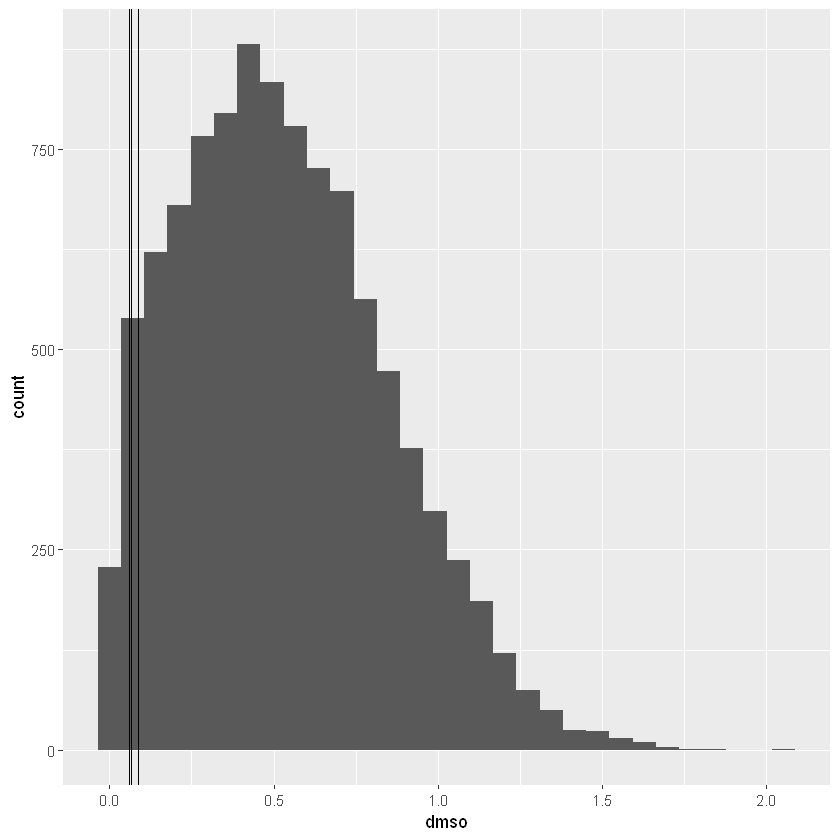

In [24]:
dmso_pred_distro_df <- data.frame(dmso = dmso_pred_distro)

ggplot(dmso_pred_distro_df, aes(x=dmso)) +
    geom_histogram() +
    geom_vline(xintercept = 0.061) +
    geom_vline(xintercept = 0.066) +
    geom_vline(xintercept = 0.087)

In [25]:
png("diff_distro_labeled.png", width=5000, height=5000, res=600)
ggplot(dmso_pred_distro_df, aes(x=dmso)) +
    geom_histogram() +
    geom_vline(xintercept = 0.061) +
    geom_vline(xintercept = 0.066) +
    geom_vline(xintercept = 0.087)
dev.off()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



png 
  2

We can see that the DMSO induced estrogen levels are on the extreme lower end of the distribution. In other words, what Cardona and Rudel (2021) are seeing for coumaphos is a very clear false positive result.

## Challenge 3: Deeper Dive -- Estrogen

We've seen for coumaphos that the reason it was flagged as increasing estrogen was because it was a false positive due to the DMSO levels on the plate being exceedingly low. 

My next question is -- how often do the chemicals identified by Cardona and Rudel come up as changed because they are in the lower part of the distribution?

### 1. Build the dataset

I already have the DMSO data ready to go. So now I just need to get the data for all of the rest of the chemicals. To do that I ran this query:

```
SELECT assay_component.assay_component_name, assay_component.technological_target_type_sub, chemical.chnm, chemical.casn, sample.stkc, sample.stkc_unit, mc0.apid, mc0.rowi, mc0.coli, mc0.wllt, mc0.wllq, mc0.conc, mc0.rval, srcf 
FROM mc0 
JOIN sample ON mc0.spid = sample.spid 
JOIN chemical ON sample.chid = chemical.chid 
JOIN chemicals_silent_spring_identified ON chemicals_silent_spring_identified.casn = chemical.casn 
JOIN assay_component ON assay_component.acid = mc0.acid 
WHERE mc0.acid = 594 
ORDER BY chnm, conc
```

I output that data into the ```all_chems_estradiol_levels.txt``` file.

Given this data should be monotonic, my guess is that the highest concentration should be the one where the largest fold change is -- that means that highest concentration should be the one that Cardona and Rudel used for calculating the fold change.

This next code block is going to read in the data and keep only the highest concentration for further analysis:

In [26]:
all_chems_estrogen <- as_tibble(read.table(file = "./invitrodb_queries/estrogen_up_queries_and_data/all_chems_estradiol_levels.txt", sep="\t", header=TRUE, quote="\""))
all_chems_estrogen_summary <- all_chems_estrogen %>% 
                                group_by(chnm) %>% 
                                filter(conc == max(conc)) %>%
                                arrange(chnm, conc)
head(all_chems_estrogen_summary)

all_chems_estrogen_summary[which(all_chems_estrogen_summary$chnm == "4'-Acetylbiphenyl"), ]

assay_component_name,technological_target_type_sub,chnm,casn,stkc,stkc_unit,apid,rowi,coli,wllt,wllq,conc,rval,srcf
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>
CEETOX_H295R_ESTRADIOL,Estradiol,1-(Bromomethyl)-3-phenoxybenzene,51632-16-7,100.0,mM,09Apr2014.Plate.26,2,10,t,1,100.0,1.44,2900-100644 TO3 DR 09Apr2014 Plate 26_Cyprotex.csv
CEETOX_H295R_ESTRADIOL,Estradiol,1-(Bromomethyl)-3-phenoxybenzene,51632-16-7,100.0,mM,09Apr2014.Plate.26,2,11,t,1,100.0,1.43,2900-100644 TO3 DR 09Apr2014 Plate 26_Cyprotex.csv
CEETOX_H295R_ESTRADIOL,Estradiol,1-Chloroanthraquinone,82-44-0,10.7,mM,03Sep2014.Plate.1,2,7,t,1,10.7,2.20,2900-TO3 PhIII E1K Set 2 86 DR 03Sep2014 Plate 1_Cyprotex.csv
CEETOX_H295R_ESTRADIOL,Estradiol,1-Chloroanthraquinone,82-44-0,10.7,mM,03Sep2014.Plate.1,2,6,t,1,10.7,2.55,2900-TO3 PhIII E1K Set 2 86 DR 03Sep2014 Plate 1_Cyprotex.csv
CEETOX_H295R_ESTRADIOL,Estradiol,1-Chloroanthraquinone,82-44-0,10.7,mM,10Jun2015.Plate.20,2,9,t,1,10.7,0.16,2900-TO3 165 DR 10Jun2015 Plate 20A.csv
CEETOX_H295R_ESTRADIOL,Estradiol,1-Chloroanthraquinone,82-44-0,10.7,mM,10Jun2015.Plate.20,2,8,t,1,10.7,0.18,2900-TO3 165 DR 10Jun2015 Plate 20A.csv


assay_component_name,technological_target_type_sub,chnm,casn,stkc,stkc_unit,apid,rowi,coli,wllt,wllq,conc,rval,srcf
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>
CEETOX_H295R_ESTRADIOL,Estradiol,4'-Acetylbiphenyl,92-91-1,100,mM,03Sep2014.Plate.3,2,5,t,1,100,1.91,2900-TO3 PhIII E1K Set 2 86 DR 03Sep2014 Plate 3_Cyprotex.csv
CEETOX_H295R_ESTRADIOL,Estradiol,4'-Acetylbiphenyl,92-91-1,100,mM,10Jun2015.Plate.22,2,7,t,1,100,0.12,2900-TO3 165 DR 10Jun2015 Plate 22B.csv
CEETOX_H295R_ESTRADIOL,Estradiol,4'-Acetylbiphenyl,92-91-1,100,mM,03Sep2014.Plate.3,2,4,t,1,100,2.02,2900-TO3 PhIII E1K Set 2 86 DR 03Sep2014 Plate 3_Cyprotex.csv
CEETOX_H295R_ESTRADIOL,Estradiol,4'-Acetylbiphenyl,92-91-1,100,mM,10Jun2015.Plate.22,2,6,t,1,100,0.12,2900-TO3 165 DR 10Jun2015 Plate 22B.csv


The analysis I'm going to do is rather straightforward, so I don't need to build a hierarchical model. That also means I don't need to run a hierarhical model.

So my next step is to build the function that will perform the analysis. For each group I will use the mean of the DMSO response for the plate, found in ```dmso_estrogen_summary```, and then calculate where that value sits on the DMSO distribution I modeled earlier. I will also calculate if the difference between the chemical and DMSO is outside the region of practical equivalence (ROPE). For these purposes, I will define the ROPE such that we only care about differences where the chemical is greater than DMSO, and the ROPE boundary is at a difference of 1$\mu$M, or 272.4$\mu$g; I will also look at 0.2$\mu$g/L.

That 2724$\mu$g is based on the following:

```(1e-6g)(1mol/272.4g)(1e6umol) = 0.00376umol per 1 ug```

For 10$\mu$mol, it would take ```(1ug/0.003umol) = (x/1umol)```

```1ug x 1umol = x * 0.00376umol```

```x = 1ug x 272.4```

```x = 272.4ug```

To be very clear, at 0.44$\mu$g/L of estrogen in DMSO, even a 4x change would be 1.76$\mu$g/L. That would be a difference of:

```(1.76ug * 0.00376umol/ug) - (0.44ug * 0.00376umol/ug)```

```0.0066176 - 0.0016544 = 0.0049632 ```

0.0049632$\mu$M.

That is barely a spit in the ocean of a difference biologically speaking. It is 4.96nM difference. In other words, the fold changes that were observed in Cardona and Rudel (2021) are not biologically relevant at all. 

To demonstrate this point, following is a Michaelis-Menten example. I'm going to calculate the fractional occupancy at the estrogen receptor for 0.44$\mu$g/L of estrogen and at 4x change which would be 1.76$\mu$g/L.


In [27]:
# Michaelis-Menten equation
fractional_occupancy_fxn <- function(chem1_conc, kd1){
  fo2 <- chem1_conc / (chem1_conc + kd1)
  return(fo2)
}

# bring the ug/L values into M
chem_conc_1 <- (0.44/272.4) * 1e-6
chem_conc_2 <- (0.44*4/272.4) * 1e-6

chem_conc_3 <- 1e-12
chem_conc_4 <- 4e-12

#Using equation 4 from Craig 1993: https://www.sciencedirect.com/science/article/pii/016561479390070Z
e2_ic50 <- 5.9e-9
e2_conc <- 2e-9
e2_ec50 <- 17.6e-12
e2_pillon_kd <- e2_ic50 / (1+(e2_conc/e2_ec50)) 

fo_c1 <- fractional_occupancy_fxn(chem_conc_1, e2_pillon_kd)
fo_c2 <- fractional_occupancy_fxn(chem_conc_2, e2_pillon_kd)
fo_c3 <- fractional_occupancy_fxn(chem_conc_3, e2_pillon_kd)
fo_c4 <- fractional_occupancy_fxn(chem_conc_4, e2_pillon_kd)

round(fo_c1, 2)
round(fo_c2, 2)
round(fo_c3, 2)
round(fo_c4, 2)

[1] 0.97

[1] 0.99

[1] 0.02

[1] 0.07

To be clear, if you're at the lower asymptote or the upper asymptote, a 4x change will not make a difference. If you are in the middle of the curve, a 4x change may lead to a drastic increase in fractional occupancy, but it will not lead to a significant increase in biological activity of the estrogen receptor.

Next we are going to see what the fractional occupancy of estradiol looks like at its peak during the menstrual cycle, where E2 peaks at 200pg/mL to 500pg/mL (https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/estradiol-blood-level). 

In [28]:
# the following converts from pg/mL to M
fractional_occupancy_fxn((200e-12 * 1000) / 272.4, e2_pillon_kd)
fractional_occupancy_fxn((500e-12 * 1000) / 272.4, e2_pillon_kd)

[1] 0.9344937

[1] 0.9727255

In cycling females, E2 tends to reach fractional occupancy levels of 93-97% in order to have generate a surge of GnRH from the hypothalamus to stimulate the LH surge from the pituitary. Thus, these values reflect the appoximate biological values required for ovulation, and thus, a true endocrine response.

Keep in mind that this means that the vehicle is already causing the generation of extremely high levels of estradiol in this model system -- to the order of 97% receptor occupancy. That means, by default, unless the test chemical is somehow an antagonist, any level of estradiol being generated is extremely high already. That is not necessarily a fault, but it is something to keep in mind, as it means that we cannot directly compare the estrogen production levels in this assay with estrogen production levels in vivo.

This brings me back to a critical point, though -- at what level do I say that estrogen production is biologically meaningfully different from 0 difference compared to DMSO? Naively I might say that we need to take DMSO as a baseline value, and then we would say 0.2$\mu$g/L or 73.4nM (that is 200pg/mL, the amount of estrogen that results in 93% receptor occupancy) is the critical difference. However, that is not necessarily getting us at the point we are trying to make, as the in vitro model is vastly different from the in vivo situation, not only in the cells that are being used, especially the lineage of the in vitro cells, but also the numbers of cells that may be participating in the production, and the prediliction of those cells for producing certain products. 

In fact, one concern that I have is that the system may be taxed by DMSO, and perhaps the system is not as sensitive as it should be. Alternatively, DMSO could also be priming the system for producing even more E2 than it normally would be.

However, in the absence of good alternatives, I will settle on using a difference of 0.2$\mu$g/L and 1.0$\mu$g/L as the boundary level. What this means is that the 95% highest density interval for the difference must be greater than 0.2$\mu$g/L in one case, and 1.0$\mu$g/L in another case, to be considered different.

Next, I'm going to calculate the analysis results across all of the chemicals. This will include the DMSO values, the percentage locations of the DMSO values on the DMSO distribution, and the percentage of the difference greater than 0.2$\mu$g/L.

In [29]:
dmso_quantile <- function(plate_id, dmso_distro, dmso_estrogen_summary){
    dmso_plate_data <- dmso_estrogen_summary[which(dmso_estrogen_summary$apid == plate_id), 2]
    dmso_quantile <- length(which(dmso_distro < pull(dmso_plate_data, mean))) / length(dmso_distro)
    return(dmso_quantile)
}

diff_quant <- function(chem_data, dmso_distro, dmso_sd_distro, threshold=0.2){
    chemical_distro <- vector(mode="double", length = 10000)
    for(i in 1:10000){
        repeat{
            chemical_distro[i] <- rnorm(1, chem_data, dmso_sd_distro[i])
            if(length(which(chemical_distro < 0)) == 0){break}
        }
    }
    diff_distro <- chemical_distro - dmso_distro
    crit <- length(which(diff_distro > threshold))/length(diff_distro)
    return(crit)
}

In [30]:
all_chems_estrogen_trim <- all_chems_estrogen_summary[, c(3, 12, 13)]

all_chems_estrogen_max_mean <- all_chems_estrogen_trim %>% 
                                group_by(chnm) %>% 
                                filter(conc == max(conc)) %>%
                                arrange(chnm, conc) %>%
                                summarize(mean = mean(rval))
head(all_chems_estrogen_max_mean)

chnm,mean
<chr>,<dbl>
1-(Bromomethyl)-3-phenoxybenzene,1.4350
1-Chloroanthraquinone,1.2725
1-Methyl-3-phenyl-5-(3-(trifluoromethyl)phenyl)-4-pyridone,0.1750
"1,2-Phenylenediamine",0.8650
"1,3-Dichloro-6,7,8,9,10,12-hexahydroazepino[2,1-b]quinazoline hydrochloride (1:1)",0.1750
"1,4-Benzenediamine",0.3350


In [31]:
all_chems_estrogen <- as_tibble(read.table(file = "./invitrodb_queries/estrogen_up_queries_and_data/all_chems_estradiol_levels.txt", sep="\t", header=TRUE))
all_chems_estrogen_plates <- all_chems_estrogen %>% 
                                group_by(chnm) %>% 
                                filter(conc == max(conc)) %>%
                                arrange(chnm, conc) %>% 
                                distinct(apid)
head(all_chems_estrogen_plates)

chnm,apid
<chr>,<chr>
1-(Bromomethyl)-3-phenoxybenzene,09Apr2014.Plate.26
1-Chloroanthraquinone,03Sep2014.Plate.1
1-Chloroanthraquinone,10Jun2015.Plate.20
1-Methyl-3-phenyl-5-(3-(trifluoromethyl)phenyl)-4-pyridone,10Jun2015.Plate.11
"1,2-Phenylenediamine",02Apr2014.Plate.10
"1,3-Dichloro-6,7,8,9,10,12-hexahydroazepino[2,1-b]quinazoline hydrochloride (1:1)",26Mar2014.Plate.18


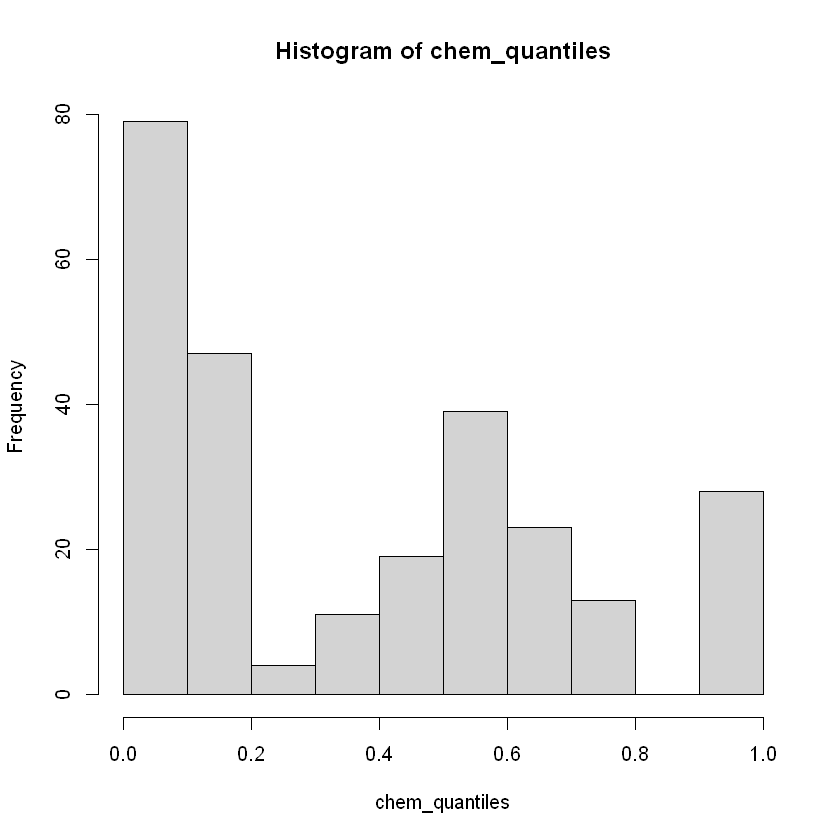

In [32]:
chem_quantiles <- sapply(all_chems_estrogen_plates$apid, dmso_quantile, dmso_pred_distro, dmso_estrogen_summary)
hist(chem_quantiles)

In [33]:
png("dmso_estrogen_chem_quantiles.png", width=5000, height=5000, res=600)
hist(chem_quantiles)
dev.off()

png 
  2

In [34]:
length(which(chem_quantiles <=0.25))/length(chem_quantiles)
length(which(chem_quantiles < .50))/length(chem_quantiles)

[1] 0.4790875

[1] 0.608365

What we see from the histogram above is that approximately 48% of the chemicals that Cardona and Rudel (2021) identified have DMSO estrogen levels at or below the 25th percentile of the DMSO estrogen concentration distribution. 

In [35]:
all_chems_estrogen_plates$percentile <- chem_quantiles
unique_chems <- unique(all_chems_estrogen_plates$chnm)
percentile_25_chems <- unique(all_chems_estrogen_plates[which(all_chems_estrogen_plates$percentile <= 0.25), 1])
length(pull(percentile_25_chems, chnm))/length(unique_chems)

all_chems_estrogen_plates$percentile <- chem_quantiles
unique_chems <- unique(all_chems_estrogen_plates$chnm)
percentile_25_chems <- unique(all_chems_estrogen_plates[which(all_chems_estrogen_plates$percentile <= 0.50), 1])
length(pull(percentile_25_chems, chnm))/length(unique_chems)

[1] 0.5147679

[1] 0.649789

The 48% statistic is based on plates. Some high concentration groups for each chemical identified by Cardona and Rudel (2021) are associated with more than one plate. So, if we just look at the unique chemicals themselves, and not the plates, what we see is that about 51% of the chemicals identified by Cardona and Rudel (2021) have at least one plate where the DMSO estrogen concentration is at or below the 25th percentile. About 65% of the chemicals identified by Cardona and Rudel (2021) have a DMSO estrogen concentration below the median.

If there was better sampling, we would not expect to see the largest mass of the chemicals that change E2 levels greater than DMSO to be at or below the median. Instead, we would expect to see the DMSO levels more concentrated around the median, and far less of the mass at or below the 25th percentile. The distribution that we are seeing here is clearly a product of sampling bias.

In the next code block I'm going to calculate the difference distribution density that is outside of the ROPE. If the critical probability is greater than 95%, then the difference distribution density is outside the ROPE.

In [36]:
critical_analysis <- sapply(all_chems_estrogen_max_mean$mean, diff_quant, dmso_pred_distro, dmso_sd_distro)
all_chems_estrogen_max_mean_prob <- cbind(all_chems_estrogen_max_mean, critical_analysis)

In [37]:
all_chems_estrogen_max_mean_prob[which(all_chems_estrogen_max_mean_prob$critical_analysis > 0.95), ]

,chnm,mean,critical_analysis
,<chr>,<dbl>,<dbl>
11,17alpha-Estradiol,1042.0750,1.0000
13,17beta-Estradiol,869.6150,1.0000
24,"2,4-Dichlorophenol",7.3900,1.0000
31,3-Methyl-4-(methylthio)phenol,2.3600,0.9988
32,3-Phenoxybenzenemethanol,1.9000,0.9889
34,3-Phenylphenol,1.8275,0.9824
38,"3,3'-Dimethylbenzidine",1.8650,0.9830
50,4-Pentylphenol,1.6400,0.9640
53,5-Amino-2-methylphenol,1.5900,0.9565


This Bayesian approach identified 24 chemicals that may potentially increase estrogen levels in the assay. However, many of these are endogenous hormones, so after removing those, we are left with 19 chemicals. Of these, 2 chemicals have QC-OMIT flags in the ICE database: 5-Amino-2-methylphenol and Sodium 2-phenylphenate tetrahydrate. So that leaves us at 17 chemicals that are eligible for additional screening. But recall, the ToxCast assays still suffer from sampling bias, these assays are statistically underpowered, so it is entirely plausible that these results are all still false positives. 

Why would I say that the assays may be suffering from sampling bias? Because typically ToxCast assays only have 2 replicates for each chemcial concentration. Having so few samples means that we cannot possibly get a good representation of the underlying population response. And in this case, the population response is for the cells in the culture. Is that inherently bad? No, not inherently bad, but it is limiting -- significantly limiting. It may be okay for a screening assay (keep in mind that we do not have a great idea of the sensitivity of the assay, so we cannot say for sure), but it certainly is not fit-for-purpose when it comes to risk assessment.

It would be a significant stretch to say that we "identified 16 chemicals that increase estrogen levels". From a chemical screening standpoint, which is the purpose ToxCast is fit for, these 16 chemicals are good candidates for followup and additional analysis. But we need to understand that these 16 chemicals are just as likely to be false positives at this point.

Regardless, this is far fewer than the number of chemicals Cardone and Rudel (2021) identified. 

In [38]:
critical_analysis_1 <- sapply(all_chems_estrogen_max_mean$mean, diff_quant, dmso_pred_distro, dmso_sd_distro, threshold=1.0)
all_chems_estrogen_max_mean_prob_1 <- cbind(all_chems_estrogen_max_mean, critical_analysis_1)
all_chems_estrogen_max_mean_prob_1[which(all_chems_estrogen_max_mean_prob_1$critical_analysis > 0.95), ]

,chnm,mean,critical_analysis_1
,<chr>,<dbl>,<dbl>
11,17alpha-Estradiol,1042.075,1.0000
13,17beta-Estradiol,869.615,1.0000
24,"2,4-Dichlorophenol",7.390,1.0000
31,3-Methyl-4-(methylthio)phenol,2.360,0.9502
84,Colforsin,4.130,1.0000
107,Equilin,113.875,1.0000
108,Estriol,17.220,1.0000
109,Estrone,364.180,1.0000
168,Testosterone propionate,7.180,1.0000


If I try a threshold of 1.0, we can see that the number of chemicals drops precipitously to 8. Once we remove the estrogens, we are left with 3 chemicals. At the end of the day, what really matters is how many chemicals is someone willing to follow-up on properly? If they have the resources to go after 17 chemicals, and to do it properly, then the lower threshold at 0.2$\mu$g/L makes sense. If they do not have the resources to do all 17 chemicals, then perhaps using a threshold of 1.0$\mu$g/L is far more reasonable.

## Challenge 4: Deeper Dive -- Progesterone

I will take the same tact as I did for estrogen -- get the DMSO distribution, analyze the data for the chemicals identified by Cardona and Rudel (2021) and see what's going on. 

I'll start off with the DMSO distribution.

### DMSO: Build the Dataset

integer(0)

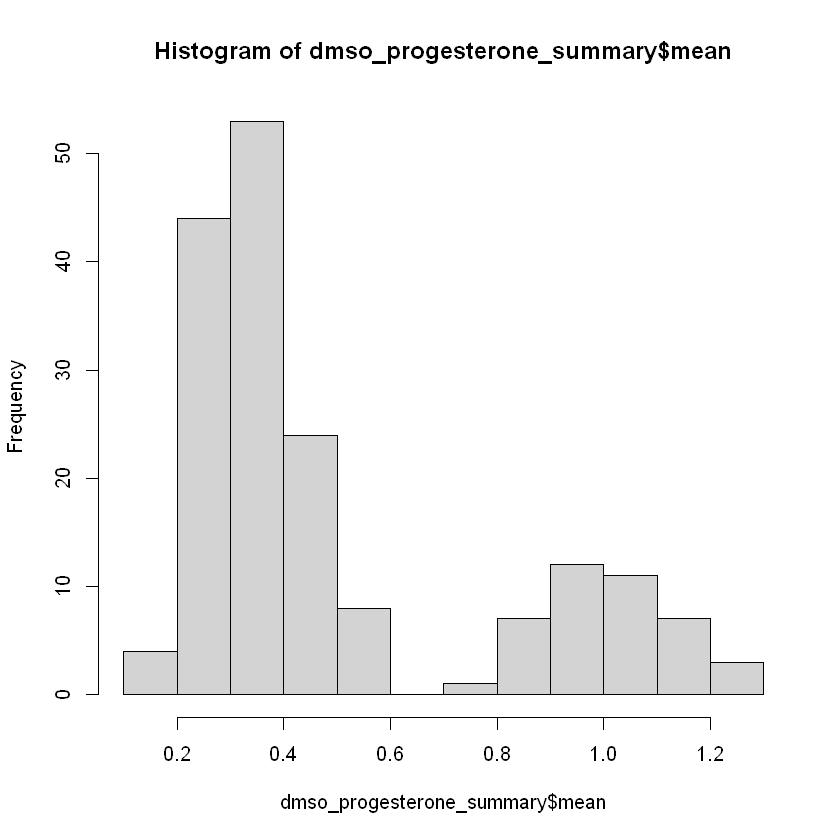

In [39]:
dmso_progesterone <- as_tibble(read.table(file = "./invitrodb_queries/progesterone_up_queries_and_data/dmso_progesterone_levels.txt", sep="\t", header=TRUE))
dmso_progesterone_summary <- dmso_progesterone %>% group_by(apid) %>% summarize(mean=mean(rval), se=sd(rval)/sqrt(n()))
dmso_progesterone_summary[which(is.na(dmso_progesterone_summary$se)), 3] <- mean(dmso_progesterone_summary$se, na.rm=TRUE)
dmso_progesterone_summary[which(dmso_progesterone_summary$se == 0), 3] <- mean(dmso_progesterone_summary$se, na.rm=TRUE)
which(is.na(dmso_progesterone_summary$se))
hist(dmso_progesterone_summary$mean)

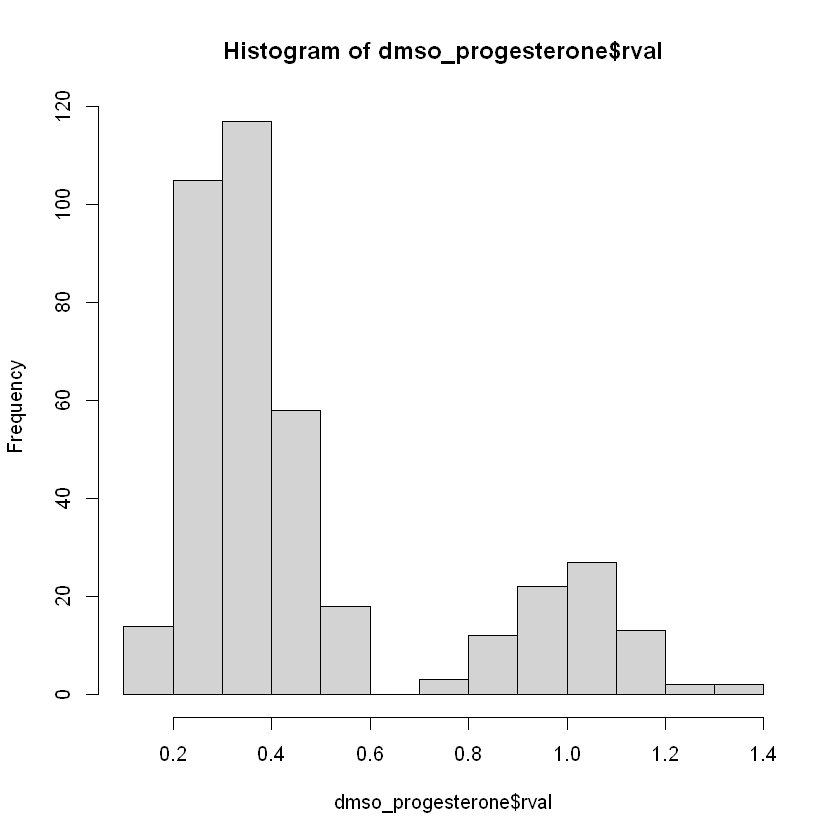

In [40]:
hist(dmso_progesterone$rval)

In [41]:
png("dmso_progesterone_rval_bimodal.png", width=5000, height=5000, res=600)
hist(dmso_progesterone$rval)
dev.off()

png 
  2

There is something definitely wrong with the DMSO data for progesterone. It appears to be a bimodal distribution, which is quite unexpected for an in vitro assay. The first histogram shows the distribution of the mean values. The second histogram shows the distribution of the raw values. This begs the question, "what is causing this?"

My first hypothesis is that this is a batch effect that will show up as clustering by date the assay was run. So let's examine that first.

In [42]:
plate_info_dmso <- t(as.data.frame(str_split(dmso_progesterone$apid, "\\.")))
colnames(plate_info_dmso) <- c("date", "label", "plate_number")
head(plate_info_dmso)

dmso_progesterone_plate_info <- data.frame(dmso_progesterone, plate_info_dmso)
head(dmso_progesterone_plate_info)

# head(as.Date(dmso_progesterone_plate_info$date, "%d%b%Y"))



,date,label,plate_number
c..09Apr2014....Plate....24..,09Apr2014,Plate,24
c..03Sep2014....Plate....19..,03Sep2014,Plate,19
c..09Apr2014....Plate....31..,09Apr2014,Plate,31
c..20130320....Plate....1..,20130320,Plate,1
c..09Apr2014....Plate....8..,09Apr2014,Plate,8
c..02Apr2014....Plate....1..,02Apr2014,Plate,1


,spid,apid,rowi,coli,wllt,wllq,conc,rval,date,label,plate_number
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>
c..09Apr2014....Plate....24..,DMSO,09Apr2014.Plate.24,6,3,n,1,0,0.3200000,09Apr2014,Plate,24
c..03Sep2014....Plate....19..,DMSO,03Sep2014.Plate.19,6,3,n,1,0,0.2500000,03Sep2014,Plate,19
c..09Apr2014....Plate....31..,DMSO,09Apr2014.Plate.31,6,3,n,1,0,0.2900000,09Apr2014,Plate,31
c..20130320....Plate....1..,DMSO,20130320.Plate.1,2,3,n,1,0,0.1414214,20130320,Plate,1
c..09Apr2014....Plate....8..,DMSO,09Apr2014.Plate.8,6,3,n,1,0,0.2700000,09Apr2014,Plate,8
c..02Apr2014....Plate....1..,DMSO,02Apr2014.Plate.1,6,2,n,1,0,0.3300000,02Apr2014,Plate,1


In [43]:
date_fixer <- function(x){
    date <- as.Date(x, "%d%b%y")
#     print(paste0("original date: ", x))
    if(is.na(date)){
#         print(paste0("updated date: ", x))
        y <- paste0(substr(x,5,6),"/",substr(x,7,8),"/", substr(x,1,4))
#         print(paste0("y: ", y))
        date <- as.Date(y, "%m/%d/%Y")
#         print(paste0("updated date: ", date))
        return(date)
    }
    else{
#         print(paste0("updated date: ", date))
        return(date)        
    }
    
}

progesterone_run_dates <- sapply(dmso_progesterone_plate_info$date, date_fixer)
dmso_progesterone_plate_info$run_dates <- progesterone_run_dates
head(dmso_progesterone_plate_info)

# date_fixer("09Apr14")
# as.Date("02Apr14", "%d%b%y")

# date_fixer("20130320")

,spid,apid,rowi,coli,wllt,wllq,conc,rval,date,label,plate_number,run_dates
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>
c..09Apr2014....Plate....24..,DMSO,09Apr2014.Plate.24,6,3,n,1,0,0.3200000,09Apr2014,Plate,24,18361
c..03Sep2014....Plate....19..,DMSO,03Sep2014.Plate.19,6,3,n,1,0,0.2500000,03Sep2014,Plate,19,18508
c..09Apr2014....Plate....31..,DMSO,09Apr2014.Plate.31,6,3,n,1,0,0.2900000,09Apr2014,Plate,31,18361
c..20130320....Plate....1..,DMSO,20130320.Plate.1,2,3,n,1,0,0.1414214,20130320,Plate,1,15784
c..09Apr2014....Plate....8..,DMSO,09Apr2014.Plate.8,6,3,n,1,0,0.2700000,09Apr2014,Plate,8,18361
c..02Apr2014....Plate....1..,DMSO,02Apr2014.Plate.1,6,2,n,1,0,0.3300000,02Apr2014,Plate,1,18354


Keep in mind that R is storing the dates relative to January 1, 1970 -- so that needs to be set as the origin in the as.Date function. 

So now I'll do a simple correlation between run date and the raw value:

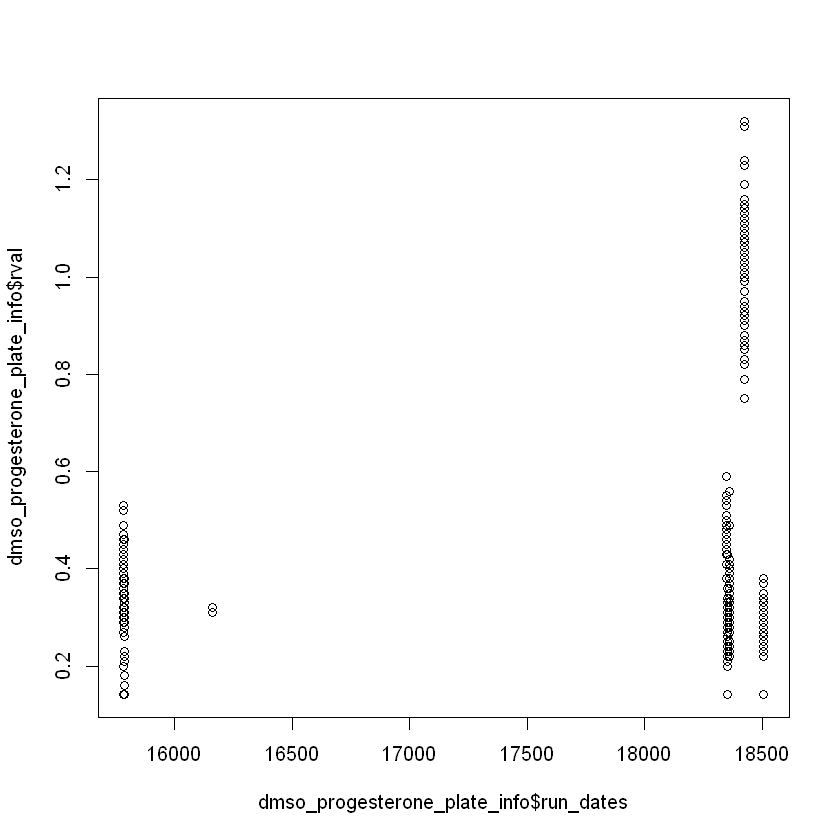

In [44]:
plot(dmso_progesterone_plate_info$run_dates, dmso_progesterone_plate_info$rval)

In [45]:
png("dmso_progesterone_date_skew.png", width=5000, height=5000, res=600)
plot(dmso_progesterone_plate_info$run_dates, dmso_progesterone_plate_info$rval)
dev.off()

png 
  2

What we see here is that there is a very large plate or date effect. The problem is that we cannot tell which is the truth and which is biased -- should the DMSO values be where the majority of the data are sitting, or should the DMSO values be at the higher level? We cannot tell. This poses a major quality issue for this data, and calls into question any results we might see if we pursue this analysis further. 

I'm going to move forward with the analysis for completeness; however, the take-home is simple: ***this data is simply of too low of quality to be trusted, even for screening purposes.***

### 2. DMSO: Build the Hierarchical Model

This is going to be a relatively straightforward hierarchical model. It's based on the Eight Schools example that's common when learning Stan. Basically, instead of schools, I have plates. And what we're trying to figure out is that mean DMSO effect on estrogen levels. And we'll be able to see what the plate effect is, too.

The Stan code is in dmso.stan.

### 3. DMSO: Prepare the data

Put the information together into a list (that's how Stan prefers things).


In [46]:
dmso_data <- list(J = nrow(dmso_progesterone_summary),
                  y = dmso_progesterone_summary$mean,
                  sigma = dmso_progesterone_summary$se)

### 4. DMSO: Run the model

In [47]:
# dmso_fit <- stan(
#                file = "dmso_ncp.stan",
#                data = dmso_data,
#                chains = 3,
#                warmup = 10000,
#                iter = 15000,
#                control = list(max_treedepth = 15))

# dmso_mod_ncp <- stan_model("dmso_ncp.stan")
dmso_mod_cp <- stan_model("dmso.stan")
dmso_fit <- sampling(
                dmso_mod_cp,
                data = dmso_data,
                chains = 3,
                warmup = 10000,
                iter = 15000,
                control = list(max_treedepth = 15))

I ran both the ncp and the cp (ncp is non-centered model and cp is the centered model; they're alternative parameterizations of the same model). The NCP model ended up giving a ton of ESS issues, so I decided to go with CP. What this means is that CP ended up yielding a better exploration of the posterior space.

In [48]:
posterior_cp <- as.array(dmso_fit)
np_cp <- nuts_params(dmso_fit)
dmso_fit

Inference for Stan model: dmso.
3 chains, each with iter=15000; warmup=10000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=15000.

            mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
mu          0.50    0.00 0.02  0.45  0.48  0.50  0.51  0.54 30433    1
tau         0.30    0.00 0.02  0.27  0.29  0.30  0.31  0.34 33952    1
theta[1]    0.32    0.00 0.00  0.31  0.31  0.31  0.32  0.32 34070    1
theta[2]    0.35    0.00 0.02  0.32  0.34  0.35  0.36  0.38 33034    1
theta[3]    0.27    0.00 0.04  0.20  0.25  0.27  0.30  0.35 35500    1
theta[4]    0.32    0.00 0.02  0.28  0.31  0.32  0.33  0.36 33968    1
theta[5]    0.26    0.00 0.00  0.25  0.25  0.26  0.26  0.26 32486    1
theta[6]    0.24    0.00 0.00  0.23  0.23  0.24  0.24  0.24 36107    1
theta[7]    0.27    0.00 0.00  0.26  0.26  0.27  0.27  0.27 34233    1
theta[8]    0.24    0.00 0.03  0.17  0.21  0.24  0.26  0.31 34841    1
theta[9]    0.30    0.00 0.00  0.30  0.30  0.31  0.31  0.31 31954 

Next, I'm going to run a diagnostic plot, just to see how things are going. Based on what I'm seeing above, I'm really comfortable with this parameterization of the hierarchical model. Basically, I have my overall treatment effect, and I have a good idea of what the different plate effects are. 

Keep in mind mu, $\mu$, is the treatment mean, tau, $\tau$, is the treatment standard deviation, and each of the thetas, $\theta [i]$, are the individual plate effects.

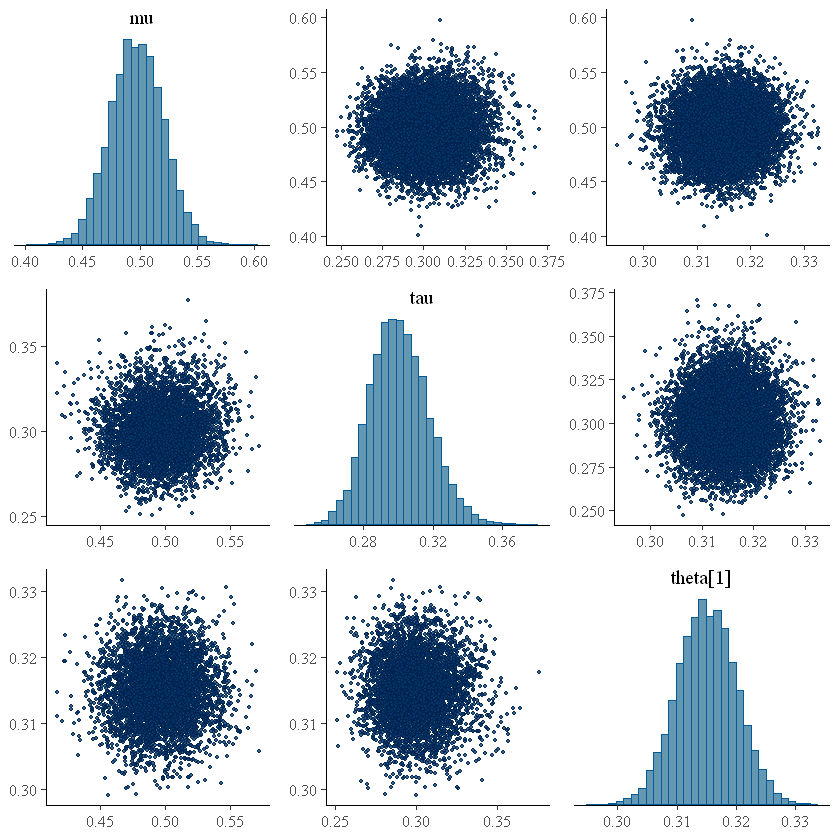

In [49]:
mcmc_pairs(posterior_cp, np = np_cp, pars = c("mu","tau","theta[1]"),
           off_diag_args = list(size = 0.75))

The diagnostic plots here are looking good. This is what I'd expect given there were no issues/warnings thrown by Stan.

So, we have a treatment mean of 0.50 and a standard deviation of 0.30. Coincidentally, is similar to what we saw for DMSO in the estrogen runs.

Out of curiosity, I'm wondering what the pooled mean and standard deviation would have been (simple average and standard deviation without doing the hierarchical modeling). Let's see:

In [50]:
dmso_progesterone %>% summarize(mean=mean(rval), sd=sd(rval))

mean,sd
<dbl>,<dbl>
0.4803888,0.2895522


Kinda cool that really, at the end of the day, the mean from the hierarchical model is pretty close to the simple pooled mean and standard deviation of 0.42 and 0.38. This means that the plate effects aren't really all that much. It also means that the distribution is actually relatively flat.

I'm going to use the hierarchical model mean and standard deviation going forward. And here's what the histogram looks like:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



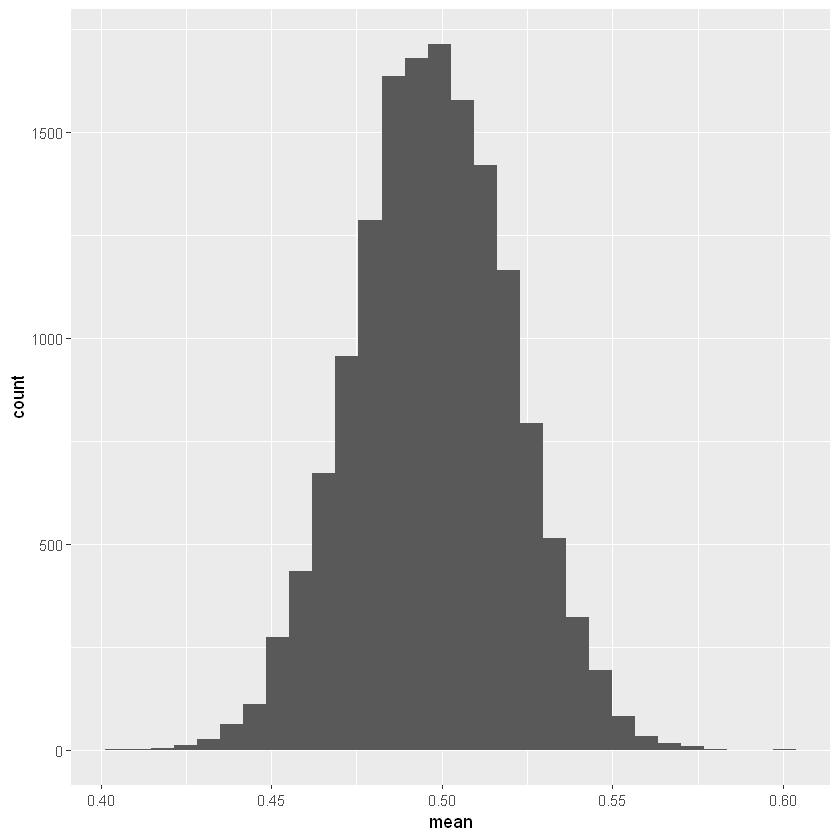

2.5%       50%     97.5% 
0.4531452 0.4974115 0.5420463

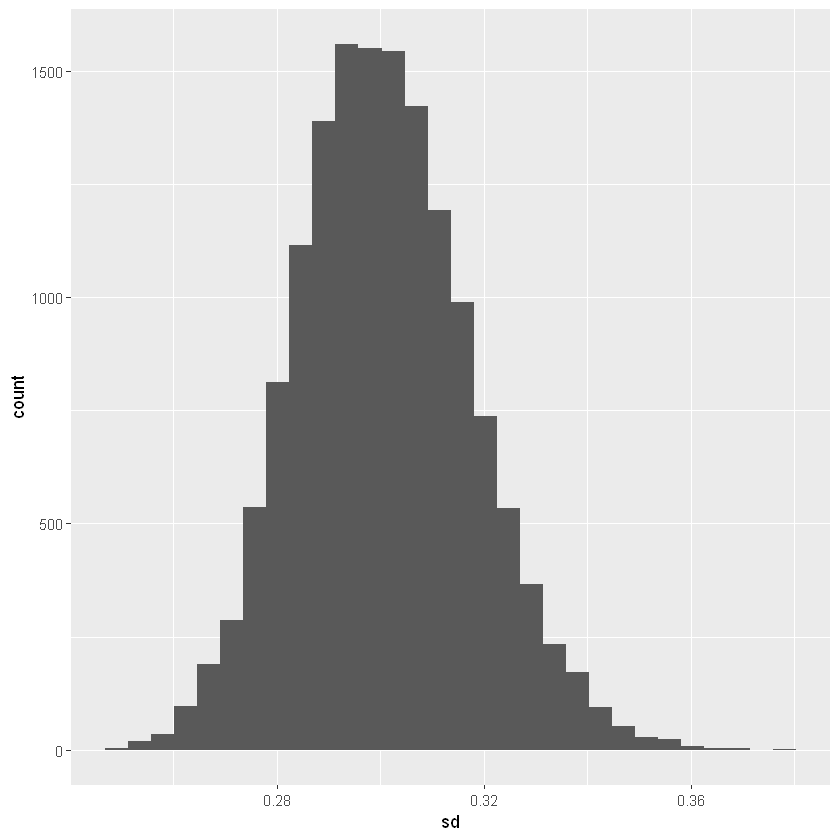

In [51]:
dmso_mean_distro <- extract(dmso_fit)$mu
dmso_sd_distro <- extract(dmso_fit)$tau

dmso_mean_sd_distro_df <- data.frame(mean = dmso_mean_distro, sd = dmso_sd_distro)

ggplot(dmso_mean_sd_distro_df, aes(x=mean)) +
    geom_histogram()

ggplot(dmso_mean_sd_distro_df, aes(x=sd)) +
    geom_histogram()

quantile(dmso_mean_distro, c(0.025, 0.5, 0.975))

So we can see that the mean has a median of 0.50 and a Bayesian interval of [0.45, 0.54]. Thus, the mean and median are likely within that range.

### 1. Build the dataset

I now have the DMSO data ready to go. So now I just need to get the data for all of the rest of the chemicals. To do that I ran this query:

```
SELECT assay_component.assay_component_name, assay_component.technological_target_type_sub, chemical.chnm, chemical.casn, sample.stkc, sample.stkc_unit, mc0.apid, mc0.rowi, mc0.coli, mc0.wllt, mc0.wllq, mc0.conc, mc0.rval, srcf 
FROM mc0 
JOIN sample ON mc0.spid = sample.spid 
JOIN chemical ON sample.chid = chemical.chid 
JOIN chemicals_silent_spring_identified ON chemicals_silent_spring_identified.casn = chemical.casn
JOIN assay_component ON assay_component.acid = mc0.acid 
WHERE mc0.acid = 597 
ORDER BY chnm, conc
```

I output that data into the ```all_chems_progesterone_levels.txt``` file.

Given this data should be monotonic, my guess is that the highest concentration should be the one where the largest fold change is -- that means that highest concentration should be the one that Cardona and Rudel used for calculating the fold change.

This next code block is going to read in the data and keep only the highest concentration for further analysis:

In [52]:
all_chems_progesterone <- as_tibble(read.table(file = "./invitrodb_queries/progesterone_up_queries_and_data/all_chems_progesterone_levels.txt", sep="\t", header=TRUE, quote="\""))
all_chems_progesterone_summary <- all_chems_progesterone %>% 
                                group_by(chnm) %>% 
                                filter(conc == max(conc)) %>%
                                arrange(chnm, conc)
head(all_chems_progesterone_summary)

assay_component_name,technological_target_type_sub,chnm,casn,stkc,stkc_unit,apid,rowi,coli,wllt,wllq,conc,rval,srcf
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>
CEETOX_H295R_PROG,Progesterone,1-(Bromomethyl)-3-phenoxybenzene,51632-16-7,100.0,mM,09Apr2014.Plate.26,2,10,t,1,100.0,0.21,2900-100644 TO3 DR 09Apr2014 Plate 26_Cyprotex.csv
CEETOX_H295R_PROG,Progesterone,1-(Bromomethyl)-3-phenoxybenzene,51632-16-7,100.0,mM,09Apr2014.Plate.26,2,11,t,1,100.0,0.24,2900-100644 TO3 DR 09Apr2014 Plate 26_Cyprotex.csv
CEETOX_H295R_PROG,Progesterone,1-Chloroanthraquinone,82-44-0,10.7,mM,03Sep2014.Plate.1,2,7,t,1,10.7,0.36,2900-TO3 PhIII E1K Set 2 86 DR 03Sep2014 Plate 1_Cyprotex.csv
CEETOX_H295R_PROG,Progesterone,1-Chloroanthraquinone,82-44-0,10.7,mM,10Jun2015.Plate.20,2,8,t,1,10.7,0.80,2900-TO3 165 DR 10Jun2015 Plate 20A.csv
CEETOX_H295R_PROG,Progesterone,1-Chloroanthraquinone,82-44-0,10.7,mM,03Sep2014.Plate.1,2,6,t,1,10.7,0.35,2900-TO3 PhIII E1K Set 2 86 DR 03Sep2014 Plate 1_Cyprotex.csv
CEETOX_H295R_PROG,Progesterone,1-Chloroanthraquinone,82-44-0,10.7,mM,10Jun2015.Plate.20,2,9,t,1,10.7,0.92,2900-TO3 165 DR 10Jun2015 Plate 20A.csv


The analysis I'm going to do is rather straightforward, so I don't need to build a hierarchical model. That also means I don't need to run a hierarhical model.

So my next step is to build the function that will perform the analysis. For each group I will use the mean of the DMSO response for the plate, found in ```dmso_progesterone_summary```, and then calculate where that value sits on the DMSO distribution I modeled earlier. I will also calculate if the difference between the chemical and DMSO is outside the region of practical equivalence (ROPE). For these purposes, I will define the ROPE such that we only care about differences where the chemical is greater than DMSO, and the ROPE boundary is at a difference of 1$\mu$M, or 314.46$\mu$g; I will also look at 0.2$\mu$g/L.

That 3144.6$\mu$g is based on the following:

```(1e-6g)(1mol/314.46g)(1e6umol) = 0.00318umol per 1 ug```

For 10$\mu$mol, it would take ```(1ug/0.00318umol) = (x/1umol)```

```1ug x 1umol = x * 0.00318umol```

```x = 1ug x 314.46```

```x = 314.46ug```

To be very clear, at 0.50$\mu$g/L of progesterone in DMSO, even a 4x change would be 2.00$\mu$g/L. That would be a difference of:

```(2.00ug * 0.00318umol/ug) - (0.50ug * 0.00318umol/ug)```

```0.00636 - 0.001905 = 0.004455 ```

0.004455$\mu$M.

That is barely a spit in the ocean of a difference biologically speaking. It is 4.45nM difference. In other words, the fold changes that were observed in Cardona and Rudel (2021) are not biologically relevant at all. 

In the absence of good alternatives, I will settle on using a difference of 0.2$\mu$g/L and 1.0$\mu$g/L as the boundary level. What this means is that the 95% highest density interval for the difference must be greater than 0.2$\mu$g/L in one case, and 1.0$\mu$g/L in another case, to be considered different.

Next, I'm going to calculate the analysis results across all of the chemicals. This will include the DMSO values, the percentage locations of the DMSO values on the DMSO distribution, and the percentage of the difference greater than 0.2$\mu$g/L.

In [53]:
all_chems_progesterone_trim <- all_chems_progesterone_summary[, c(3, 12, 13)]

all_chems_progesterone_max_mean <- all_chems_progesterone_trim %>% 
                                group_by(chnm) %>% 
                                filter(conc == max(conc)) %>%
                                arrange(chnm, conc) %>%
                                summarize(mean = mean(rval))
head(all_chems_progesterone_max_mean)

chnm,mean
<chr>,<dbl>
1-(Bromomethyl)-3-phenoxybenzene,0.2250
1-Chloroanthraquinone,0.6075
1-Methyl-3-phenyl-5-(3-(trifluoromethyl)phenyl)-4-pyridone,0.6200
"1,2-Phenylenediamine",0.4100
"1,3-Dichloro-6,7,8,9,10,12-hexahydroazepino[2,1-b]quinazoline hydrochloride (1:1)",0.3950
"1,4-Benzenediamine",0.4900


In [54]:
all_chems_progesterone <- as_tibble(read.table(file = "./invitrodb_queries/progesterone_up_queries_and_data/all_chems_progesterone_levels.txt", sep="\t", header=TRUE))
all_chems_progesterone_plates <- all_chems_progesterone %>% 
                                group_by(chnm) %>% 
                                filter(conc == max(conc)) %>%
                                arrange(chnm, conc) %>% 
                                distinct(apid)
head(all_chems_progesterone_plates)

chnm,apid
<chr>,<chr>
1-(Bromomethyl)-3-phenoxybenzene,09Apr2014.Plate.26
1-Chloroanthraquinone,03Sep2014.Plate.1
1-Chloroanthraquinone,10Jun2015.Plate.20
1-Methyl-3-phenyl-5-(3-(trifluoromethyl)phenyl)-4-pyridone,10Jun2015.Plate.11
"1,2-Phenylenediamine",02Apr2014.Plate.10
"1,3-Dichloro-6,7,8,9,10,12-hexahydroazepino[2,1-b]quinazoline hydrochloride (1:1)",26Mar2014.Plate.18


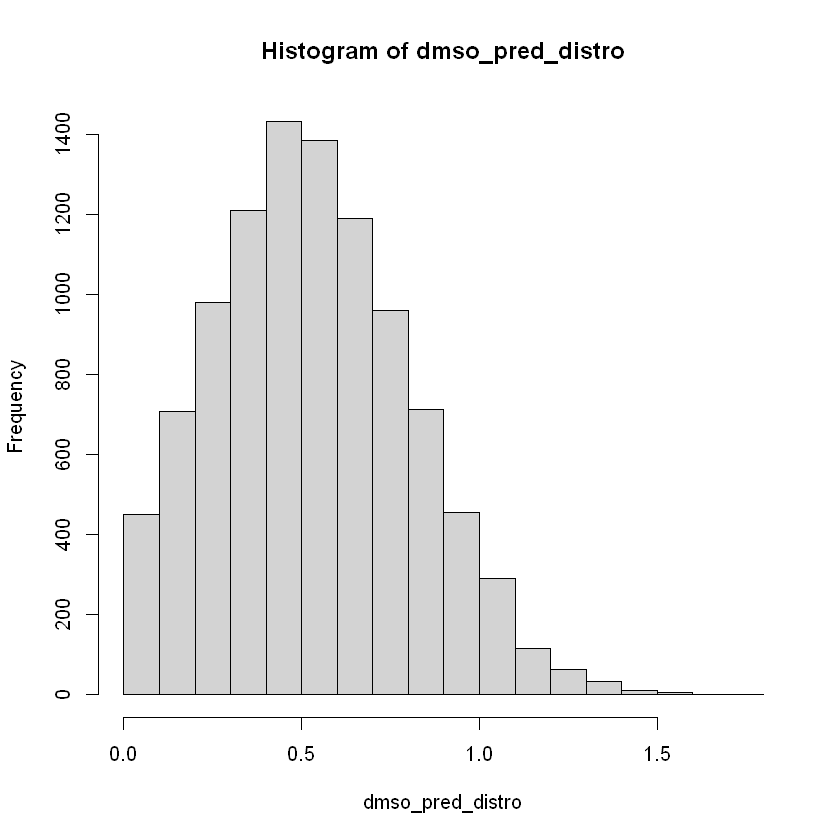

In [55]:
dmso_pred_distro <- vector(mode="double", length = 10000)
for(i in 1:10000){
    repeat{
        dmso_pred_distro[i] <- rnorm(1, dmso_mean_distro[i], dmso_sd_distro[i])
        if(length(which(dmso_pred_distro < 0)) == 0){break}
    }
}
hist(dmso_pred_distro)

In [56]:
png("dmso_pred_distro_progesterone.png", width=5000, height=5000, res=600)
hist(dmso_pred_distro)
dev.off()

png 
  2

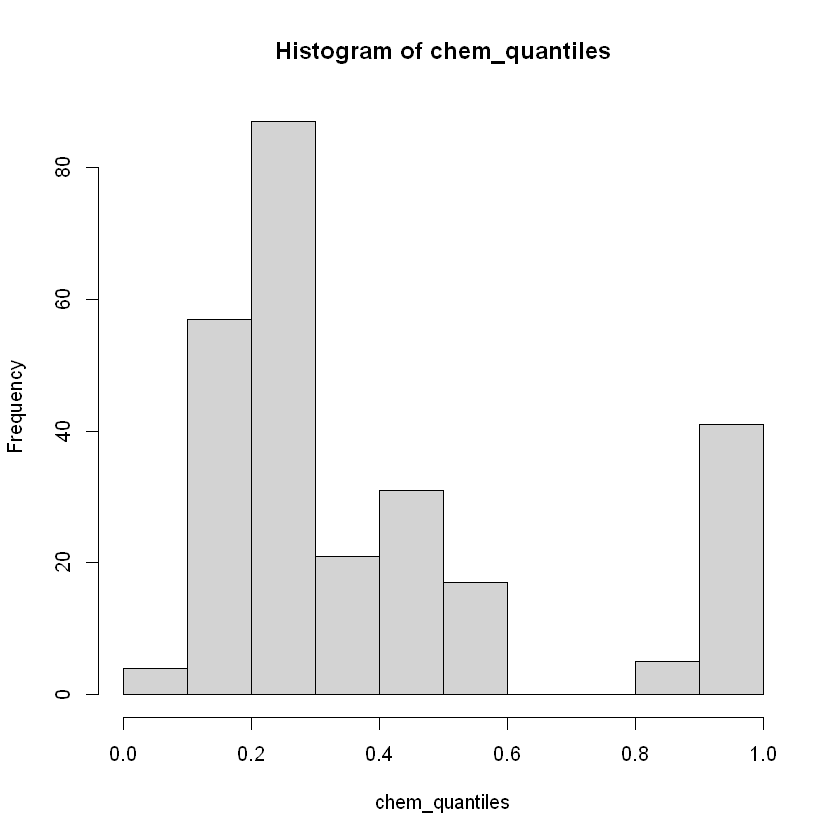

In [57]:
chem_quantiles <- sapply(all_chems_progesterone_plates$apid, dmso_quantile, dmso_pred_distro, dmso_progesterone_summary)
hist(chem_quantiles)

In [58]:
length(which(chem_quantiles <=0.25))/length(chem_quantiles)
length(which(chem_quantiles < .50))/length(chem_quantiles)

[1] 0.4448669

[1] 0.7604563

What we see from the histogram above is that approximately 44% of the chemicals that Cardona and Rudel (2021) identified have DMSO progesterone levels at or below the 25th percentile of the DMSO estrogen concentration distribution. 

In [59]:
all_chems_progesterone_plates$percentile <- chem_quantiles
unique_chems <- unique(all_chems_progesterone_plates$chnm)
percentile_25_chems <- unique(all_chems_progesterone_plates[which(all_chems_progesterone_plates$percentile <= 0.25), 1])
length(pull(percentile_25_chems, chnm))/length(unique_chems)

all_chems_progesterone_plates$percentile <- chem_quantiles
unique_chems <- unique(all_chems_progesterone_plates$chnm)
percentile_25_chems <- unique(all_chems_progesterone_plates[which(all_chems_progesterone_plates$percentile <= 0.50), 1])
length(pull(percentile_25_chems, chnm))/length(unique_chems)

[1] 0.4936709

[1] 0.8227848

The 44% statistic is based on plates. Some high concentration groups for each chemical identified by Cardona and Rudel (2021) are associated with more than one plate. So, if we just look at the unique chemicals themselves, and not the plates, what we see is that about 49% of the chemicals identified by Cardona and Rudel (2021) have at least one plate where the DMSO estrogen concentration is at or below the 25th percentile. About 82% of the chemicals identified by Cardona and Rudel (2021) have a DMSO estrogen concentration below the median.

If there was better sampling, we would not expect to see the largest mass of the chemicals that change P4 levels greater than DMSO to be at or below the median. Instead, we would expect to see the DMSO levels more concentrated around the median, and far less of the mass at or below the 25th percentile. The distribution that we are seeing here is clearly a product of sampling bias.

In the next code block I'm going to calculate the difference distribution density that is outside of the ROPE. If the critical probability is greater than 95%, then the difference distribution density is outside the ROPE.

In [60]:
critical_analysis <- sapply(all_chems_progesterone_max_mean$mean, diff_quant, dmso_pred_distro, dmso_sd_distro)
all_chems_progesterone_max_mean_prob <- cbind(all_chems_progesterone_max_mean, critical_analysis)

In [61]:
all_chems_progesterone_max_mean_prob[which(all_chems_progesterone_max_mean_prob$critical_analysis > 0.95), ]

,chnm,mean,critical_analysis
,<chr>,<dbl>,<dbl>
8,"1,5-Naphthalenediamine",2.5900,1.0000
9,"1,â€‹2-â€‹Benzenediol",1.8600,0.9960
15,2-Aminoanthraquinone,2.6900,1.0000
16,2-Ethoxy-5-(1-propenyl)phenol,1.9050,0.9971
19,2-Naphthylamine,6.7600,1.0000
34,3-Phenylphenol,3.4125,1.0000
36,"3,3'-Dimethoxybenzidine",2.4200,0.9999
38,"3,3'-Dimethylbenzidine",3.6500,1.0000
46,4-Aminoazobenzene,2.4750,1.0000


Take-home message: we cannot trust the end results of any analysis of the progesterone data given what we know at this time. Specifically, we know that there is a plate/day effect. We know that this plate/day effect is substantial. We do not know what ground truth should be for the DMSO data -- thus, we cannot say that one group of DMSO plate data is better than another group. As a result, we cannot trust the vehicle information. That means that we cannot use this data to identify chemicals that may be good candidates for following up on their ability to increase progesterone levels in vitro.

This demonstrates again that exploratory analysis is key and critical to identifying potential quality issues prior to analysis, and definitely prior to drawing any types of conclusions on flawed data.